### Objective: 

Build a prediction model to predict whether a review on the restaurant is positive or negative.

Installing opendatasets library to download the dataset

In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing opendatasets library

In [2]:
import opendatasets as od

In [3]:
# Path to the dataset website
dataset = r"https://drive.google.com/file/d/1RpNUwmlio_QdgbQkhabdeoRII4-uyD7o/view"

In [4]:
# Downloading the dataset
od.download(dataset)

61954it [00:00, 89327573.05it/s]

Downloaded to  ./RestaurantReview.csv


The dataset **RestaurantReview.csv** has been downloaded

### Importing pandas

In [5]:
import pandas as pd
import numpy as np

Reading the csv dataset as a pandas dataframe

In [6]:
Rest_rev = pd.read_csv('RestaurantReview.csv')

In [7]:
pd.set_option('display.max_colwidth', 150)

In [8]:
Rest_rev.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1
4,The selection on the menu was great and so were the prices.,1


Checking details of the dataframe

In [9]:
Rest_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0    Review  1000 non-null   object
 1   Liked    1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [10]:
Rest_rev.columns

Index([' Review', 'Liked'], dtype='object')

The column **Review** has a leading space in its name. So we can rename the column to remove this leading space

In [11]:
Rest_rev = Rest_rev.rename(columns={' Review':'Review'})

In [12]:
Rest_rev.columns

Index(['Review', 'Liked'], dtype='object')

The leading space has been removed from the **Review** column

Checking for presence of missing values

In [13]:
Rest_rev.isnull().sum()

Review    0
Liked     0
dtype: int64

There are no missing values in the dataframe

Checking for presence of duplicates

In [14]:
Rest_rev.duplicated(subset=None, keep='first').sum()

4

There are 4 duplicate records in the dataframe

In [15]:
Rest_rev.shape

(1000, 2)

Removing the duplicate records

In [16]:
Rest_rev = Rest_rev[Rest_rev.duplicated(Rest_rev.columns.tolist(), keep='first')==False]

In [17]:
Rest_rev.duplicated(subset=None, keep='first').sum()

0

In [18]:
Rest_rev.shape

(996, 2)

Duplicate records have been removed from the dataframe

In [19]:
Rest_rev.reset_index(inplace = True, drop = True)

Indices have been reset

In [20]:
Rest_rev.groupby('Liked').describe()

Review                                      
       count unique                       top freq
Liked                                             
0        497    497        Crust is not good.    1
1        499    499  Wow... Loved this place.    1

The following conclusions can be drawn from the above result:

 - The count of negative reviews is 497
 - The count of positive reviews is 499

Let's create a new column to detect how long the text messages are

In [21]:
Rest_rev['Length'] = Rest_rev['Review'].apply(len)

<ipython-input-21-b94721c73b2e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Rest_rev['Length'] = Rest_rev['Review'].apply(len)


In [22]:
Rest_rev.head(10)

,Review,Liked,Length
0,Wow... Loved this place.,1,24
1,Crust is not good.,0,18
2,Not tasty and the texture was just nasty.,0,41
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1,87
4,The selection on the menu was great and so were the prices.,1,59
5,Now I am getting angry and I want my damn pho.,0,46
6,Honeslty it didn't taste THAT fresh.),0,37
7,The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.,0,111
8,The fries were great too.,1,25
9,A great touch.,1,14


As we can observe that there is no specific pattern of length that determines whether a review is positive or negative, so the legnth of a review does not help much in determining the sentiment of the review for this use case

## Data Visualization

In [23]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

#### Plotting histogram

Text(0.5, 0, 'Length of Review')

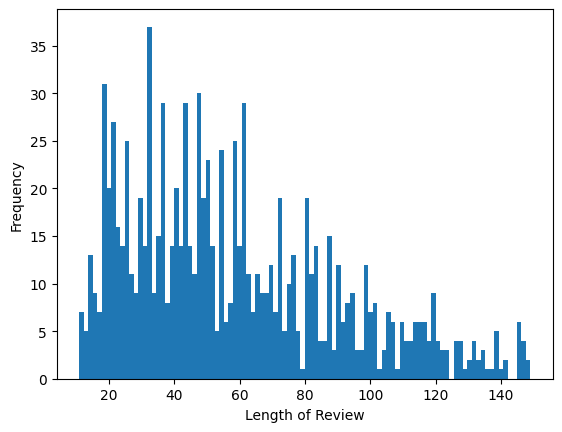

In [24]:
Rest_rev['Length'].plot(bins=100, kind='hist')
plt.xlabel('Length of Review')

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

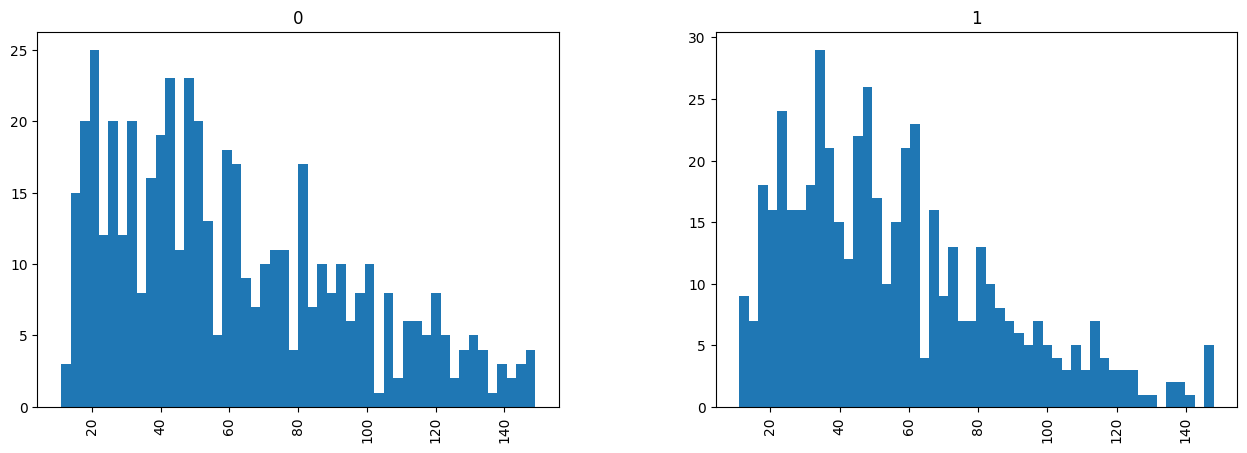

In [25]:
Rest_rev.hist(column='Length', by='Liked', bins=50, figsize=(15,5))

It can be observed from the above histogram that most of the Reviews are having lengths ranging from **20** to **60**

In [26]:
Rest_rev.Length.describe()

count    996.000000
mean      58.459839
std       32.341292
min       11.000000
25%       33.000000
50%       51.000000
75%       80.000000
max      149.000000
Name: Length, dtype: float64

The following conclusions can be drawn from the above result:

 - The mean length of reviews is 58
 - The minimum length of a reviews is 11
 - The maximum length of a review is 149

In [27]:
print("Value count for feature Liked")
print(Rest_rev['Liked'].value_counts())

Value count for feature Liked
1    499
0    497
Name: Liked, dtype: int64


#### Plotting countplot

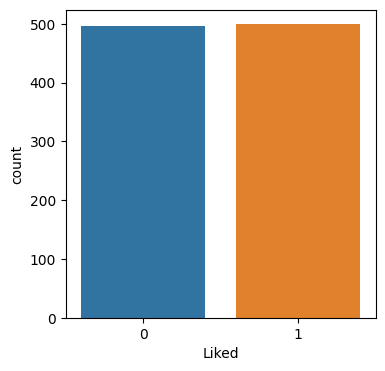

In [28]:
plt.figure(figsize=(4,4))
plt.ticklabel_format(style='plain')
ax = sns.countplot(x='Liked',data=Rest_rev)
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+50))

It can be observed that the dataframe is balanced

**Text preprocessing**

Cleaning the punctuation marks

In [29]:
import re
import string

List of punctuation marks to be removed

In [30]:
print(list(string.punctuation))

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [31]:
def remove_punctuation(text):
    no_punct = "".join([c if c not in string.punctuation else " " for c in text])
    return no_punct

In [32]:
Rest_rev['preprocessed_Review'] = Rest_rev['Review'].apply(lambda x: remove_punctuation(x))

Converting all uppercase characters to lowercase

In [33]:
Rest_rev['preprocessed_Review'] = Rest_rev['preprocessed_Review'].str.lower()

Eliminating the numbers from the **Review** column as they do not contribute in predicting the sentiment of a review

In [34]:
Rest_rev['preprocessed_Review'] = [re.sub('\d+', '', e) for e in Rest_rev['preprocessed_Review']]

Removing unnecessary spaces from the text

In [35]:
Rest_rev['preprocessed_Review'] = [re.sub('\s+', ' ', e) for e in Rest_rev['preprocessed_Review']]

Removing leading or trailing spaces from the text

In [36]:
Rest_rev['preprocessed_Review'] = Rest_rev['preprocessed_Review'].str.strip()

#### Importing nltk

In [37]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#### Tokenization

In [38]:
from nltk.tokenize import word_tokenize

In [39]:
Rest_rev['preprocessed_Review'] = Rest_rev['preprocessed_Review'].apply(word_tokenize)

In [40]:
Rest_rev.head()

,Review,Liked,Length,preprocessed_Review
0,Wow... Loved this place.,1,24,"[wow, loved, this, place]"
1,Crust is not good.,0,18,"[crust, is, not, good]"
2,Not tasty and the texture was just nasty.,0,41,"[not, tasty, and, the, texture, was, just, nasty]"
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1,87,"[stopped, by, during, the, late, may, bank, holiday, off, rick, steve, recommendation, and, loved, it]"
4,The selection on the menu was great and so were the prices.,1,59,"[the, selection, on, the, menu, was, great, and, so, were, the, prices]"


The **Review** column has been tokenized i.e. split into tokens/pieces

#### Removing the stopwords

In [41]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Loading the **English** language stopwords

In [42]:
stopwords_english = stopwords.words('english')

List of english stopwords

In [43]:
print(stopwords_english)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Certain words in the above including **not**, **until**, **while**, **against** etc may contribute to the sentiment of a review. So they may need to be retained in the review and thus need to be removed from the above list

In [44]:
stopwords_english_set = set(stopwords_english)

In [45]:
stopwords_english_set = stopwords_english_set.difference({'until', 'while', 'against', 'between', 'during', 'before', 'after', 'above', 'below', 'not'})

In [46]:
stopwords_english = list(stopwords_english_set)

In [47]:
print(stopwords_english)

['are', "shouldn't", 'have', 'few', 'very', 'yourselves', 'you', 'doing', 'such', 'those', 'of', "wouldn't", 'some', "needn't", 're', 'she', 'through', 'all', 'having', "doesn't", "wasn't", 'whom', 'by', 'we', 'haven', 'were', 'ain', 'should', 'out', 'which', 'ours', "you've", 'for', 'wasn', 'his', 'in', 'me', 'shouldn', 'own', 'the', 'more', 'and', 'into', 'further', 'he', 'that', 'what', 'mightn', 'couldn', "haven't", 'don', 'wouldn', 'their', 'shan', 'hers', 'other', 'ourselves', 'on', 'nor', 'there', 'up', 'weren', 'with', 'hadn', 'won', 'who', "hasn't", 'being', "you're", 'mustn', 'each', 'any', 'himself', "hadn't", 'is', 'isn', 'can', 'down', 'just', 'do', 'has', 'at', 'it', 'theirs', 'so', 'had', 'then', 'myself', 'themselves', 'they', 'its', 'because', 'from', 'an', 'i', 'yourself', 'am', 'my', 'her', 'herself', 'as', "mightn't", "didn't", "shan't", 'him', "won't", "you'd", 'why', 'm', 've', 'or', 'too', 'be', 'doesn', 'll', 'here', 'to', "couldn't", 'than', 'off', 'same', "she

In [48]:
def remove_stopwords(text):        
    words = [w for w in text if w not in stopwords_english]
    return words

In [49]:
Rest_rev['preprocessed_Review'] = Rest_rev['preprocessed_Review'].apply(lambda x: remove_stopwords(x))

In [50]:
Rest_rev.head()

,Review,Liked,Length,preprocessed_Review
0,Wow... Loved this place.,1,24,"[wow, loved, place]"
1,Crust is not good.,0,18,"[crust, not, good]"
2,Not tasty and the texture was just nasty.,0,41,"[not, tasty, texture, nasty]"
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1,87,"[stopped, during, late, may, bank, holiday, rick, steve, recommendation, loved]"
4,The selection on the menu was great and so were the prices.,1,59,"[selection, menu, great, prices]"


The stopwords have been removed from the **Review** column

#### Lemmatization of Reviews

**Lemmatization** shorten words back to their root form. **Lemmatizing** maps common words into one base. It returns a proper word that can be found in the dictionary

To implement Lemmatization using NLTK, we require **wordnet** and **WordNetLemmatizer**

In [51]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [52]:
from nltk.stem import WordNetLemmatizer

In [53]:
lemmatizer = WordNetLemmatizer()

In [54]:
def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

In [55]:
Rest_rev['preprocessed_Review'] = Rest_rev['preprocessed_Review'].apply(lambda x: word_lemmatizer(x))

In [56]:
Rest_rev.head()

,Review,Liked,Length,preprocessed_Review
0,Wow... Loved this place.,1,24,"[wow, loved, place]"
1,Crust is not good.,0,18,"[crust, not, good]"
2,Not tasty and the texture was just nasty.,0,41,"[not, tasty, texture, nasty]"
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1,87,"[stopped, during, late, may, bank, holiday, rick, steve, recommendation, loved]"
4,The selection on the menu was great and so were the prices.,1,59,"[selection, menu, great, price]"


Renaming the preprocessed Review to **cleaned_Review**

In [57]:
Rest_rev = Rest_rev.rename(columns={'preprocessed_Review':'cleaned_Review'})

In [58]:
Rest_rev.columns

Index(['Review', 'Liked', 'Length', 'cleaned_Review'], dtype='object')

In [59]:
Rest_rev.to_csv('Rest_rev_1.csv', index=False)

In [60]:
Rest_rev = pd.read_csv('Rest_rev_1.csv')

#### WorldCloud

Importing **WorldCloud**

In [61]:
from wordcloud import WordCloud

Fetching all the reviews from the dataframe

In [62]:
word_cloud_text = ''.join(Rest_rev['cleaned_Review'])

Creating a WorldCloud for all the reviews

In [63]:
wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

Plotting Wordcloud based on all the reviews

Word Cloud based on all the reviews


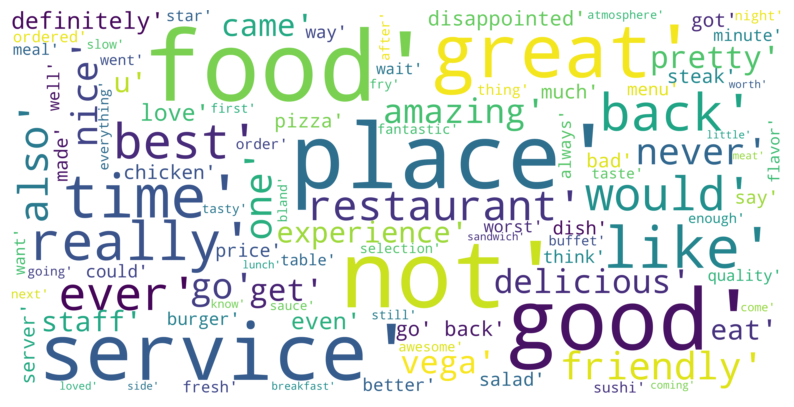

In [64]:
print('Word Cloud based on all the reviews')
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

If the frequency of a word is high, the word will appear big in the word cloud.

If the frequency of a word is low, the word will appear small in the word cloud.

Fetching all those reviews from the dataframe where the sentiment is positive

In [65]:
word_cloud_text_positive = ''.join(Rest_rev[Rest_rev['Liked']==1].cleaned_Review)

Fetching all those reviews from the dataframe where the sentiment is negative

In [66]:
word_cloud_text_negative = ''.join(Rest_rev[Rest_rev['Liked']==0].cleaned_Review)

In [67]:
wordcloud_positive = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text_positive)

In [68]:
wordcloud_negative = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text_negative)

Plotting Wordcloud based on all the positive class reviews

Word Cloud based on all the positive class reviews


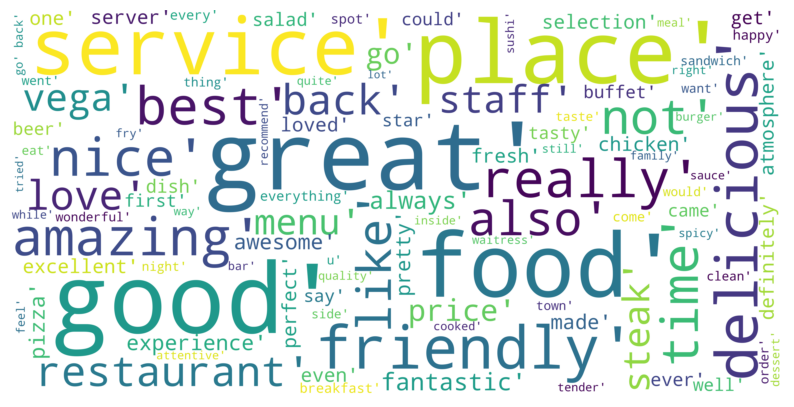

In [69]:
print('Word Cloud based on all the positive class reviews')
plt.figure(figsize=(10,10))
plt.imshow(wordcloud_positive, interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

For the above word cloud on positive reviews, the common words are **good**, **great**, **amazing**, **delicious**, **friendly**, **best**, **nice**, **love**, **fantastic**, **perfect** etc

Plotting Wordcloud based on all the negative class reviews

Word Cloud based on all the negative class reviews


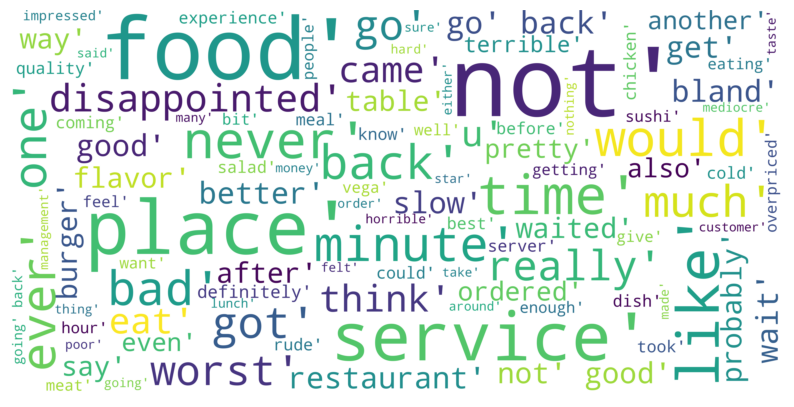

In [70]:
print('Word Cloud based on all the negative class reviews')
plt.figure(figsize=(10,10))
plt.imshow(wordcloud_negative, interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

For the above word cloud on negative reviews, the common words are **worst**, **bad**, **disappointed**, **terrible**, **slow**, **poor**, **horrible**, **overpriced**, **rude** etc

Creating two objects X and Y. X will be the ‘cleaned_Review ' column of Rest_rev data frame and Y will be the ' liked' column

In [71]:
X = Rest_rev.cleaned_Review

In [72]:
X

0                                                                                 ['wow', 'loved', 'place']
1                                                                                  ['crust', 'not', 'good']
2                                                                      ['not', 'tasty', 'texture', 'nasty']
3       ['stopped', 'during', 'late', 'may', 'bank', 'holiday', 'rick', 'steve', 'recommendation', 'loved']
4                                                                   ['selection', 'menu', 'great', 'price']
                                                       ...                                                 
991                                                       ['think', 'food', 'flavor', 'texture', 'lacking']
992                                                                       ['appetite', 'instantly', 'gone']
993                                           ['overall', 'not', 'impressed', 'would', 'not', 'go', 'back']
994               ['whole', 

In [73]:
Y = Rest_rev.Liked

In [74]:
Y

0      1
1      0
2      0
3      1
4      1
      ..
991    0
992    0
993    0
994    0
995    0
Name: Liked, Length: 996, dtype: int64

#### Train Test split

Splitting the dataframe into train and test

In [75]:
from sklearn.model_selection import train_test_split
df_train_TfIdf, df_test_TfIdf = train_test_split(Rest_rev, test_size = 0.10, random_state = 42, shuffle=True)

Resetting the indices of the training and testing dataframes

In [76]:
df_train_TfIdf.reset_index(inplace = True, drop = True)

In [77]:
df_test_TfIdf.reset_index(inplace = True, drop = True)

In [78]:
df_train_TfIdf.head()

,Review,Liked,Length,cleaned_Review
0,Ordered an appetizer and took 40 minutes and then the pizza another 10 minutes.,0,79,"['ordered', 'appetizer', 'took', 'minute', 'pizza', 'another', 'minute']"
1,"The decor is nice, and the piano music soundtrack is pleasant.",1,62,"['decor', 'nice', 'piano', 'music', 'soundtrack', 'pleasant']"
2,The problem I have is that they charge $11.99 for a sandwich that is no bigger than a Subway sub (which offers better and more amount of vegetables).,0,149,"['problem', 'charge', 'sandwich', 'bigger', 'subway', 'sub', 'offer', 'better', 'amount', 'vegetable']"
3,Not my thing.,0,13,"['not', 'thing']"
4,The poor batter to meat ratio made the chicken tenders very unsatisfying.,0,73,"['poor', 'batter', 'meat', 'ratio', 'made', 'chicken', 'tender', 'unsatisfying']"


In [79]:
df_test_TfIdf.head()

,Review,Liked,Length,cleaned_Review
0,They were excellent.,1,20,['excellent']
1,"Your servers suck, wait, correction, our server Heimer sucked.",0,62,"['server', 'suck', 'wait', 'correction', 'server', 'heimer', 'sucked']"
2,Will be back again!,1,19,['back']
3,I hate those things as much as cheap quality black olives.,0,58,"['hate', 'thing', 'much', 'cheap', 'quality', 'black', 'olive']"
4,I don't think we'll be going back anytime soon.,0,47,"['think', 'going', 'back', 'anytime', 'soon']"


The indices have been reset

#### Creating a TF-IDF object

We will create an object for **TfidfVectorizer** to convert the text data into a numeric representation/vector representation

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

Multinomial classifiers are quite useful when working with text data. Since **Multinomial Naive Bayes** algorithm is  useful for discrete counts, we can use **MultinomialNB**.

In [81]:
from sklearn.naive_bayes import MultinomialNB

In [82]:
from sklearn.pipeline import make_pipeline

We have set some parameters in the TfidfVectorizer. **max_df=0.15** means that only the words whose frequency of occurrence in the documents is a maximum of 0.15 will be considered whereas the words having frequency higher than 0.15 will not be considered as they will not matter much since they are commonly occurring in the document.

In [83]:
vectorizer_tf = TfidfVectorizer(max_df=0.15, min_df=0, max_features=10000, use_idf=False,norm=None)

We can use **make_pipeline()** function to take the output of **TfidfVectorizer()** and push that to the **MultinomialNB()**.

In [84]:
pipeline_TfIdf = make_pipeline(vectorizer_tf, MultinomialNB())

Training the model

In [85]:
pipeline_TfIdf.fit(df_train_TfIdf.cleaned_Review, df_train_TfIdf.Liked)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.15, max_features=10000, min_df=0,
                                 norm=None, use_idf=False)),
                ('multinomialnb', MultinomialNB())])

Making predictions on the testing dataset

In [86]:
labels_TfIdf = pipeline_TfIdf.predict(df_test_TfIdf.cleaned_Review)

Plotting a **confusion matrix**

In [87]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [88]:
from sklearn.metrics import precision_recall_fscore_support as score

In [89]:
mat_TfIdf = confusion_matrix(df_test_TfIdf.Liked, labels_TfIdf)

Text(113.9222222222222, 0.5, 'Predicted label')

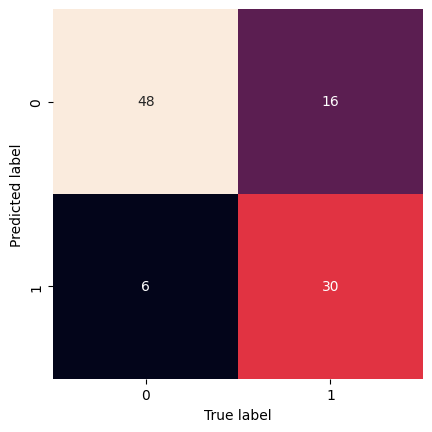

In [90]:
sns.heatmap(mat_TfIdf.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label')

The following observations can be concluded about the performance:
    
 - 72 is the number of true positives i.e. The number of actual negative reviews that were predicted negatively be the model
 - 44 is the number of true negatives i.e. The number of actual positive reviews that were predicted positively be the model
 - 13 is the number of false positives i.e. The number of actual negative reviews that were predicted positively be the model
 - 21 is the number of false negatives i.e. The number of actual positive reviews that were predicted negatively be the model

In [91]:
score_TfIdf = accuracy_score(df_test_TfIdf.Liked, labels_TfIdf)

In [92]:
score_TfIdf

0.78

The accuracy score of the **MultinomialNB** model is 77.33%

In [93]:
report_TfIdf = classification_report(df_test_TfIdf.Liked, labels_TfIdf)

In [94]:
print(report_TfIdf)

              precision    recall  f1-score   support

           0       0.75      0.89      0.81        54
           1       0.83      0.65      0.73        46

    accuracy                           0.78       100
   macro avg       0.79      0.77      0.77       100
weighted avg       0.79      0.78      0.78       100



In [95]:
precision_TfIdf,recall_TfIdf,fscore_TfIdf,support_TfIdf=score(df_test_TfIdf.Liked, labels_TfIdf,average='macro')

We will import **GridSearchCV** for Hyperparameter tuning

In [96]:
from sklearn.model_selection import GridSearchCV

In [97]:
l = [0.5, 0.5] # Taking equal priority values

In [98]:
neigh_TfIdf = MultinomialNB(fit_prior=False, class_prior=l)

The Parameter **fit_prior=False** means that the model will not calculate the prior probability values. If we want to assign our own probability values to the prior probability, we have to set **class_prior=l** 

In [99]:
alphas = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]) 

We have to identify the best alpha i.e. the learning rate. If alpha is going towards zero, then the model is overfitting. If alpha value is going up, then the model is underfitting

In [100]:
# Placing alpha values in a dictionary
tuned_parameters = {'alpha' : alphas}

As arguments, the **GridSearchCV** will take the model, the dictionary of the alpha values, apply cross validation and the accuracy metric and iterate over combinations of these

In [101]:
clf_TfIdf = GridSearchCV(neigh_TfIdf, tuned_parameters, cv=5, scoring = 'roc_auc', return_train_score=True)

In [102]:
vectorizer_tf_gridSearch = TfidfVectorizer(max_df=0.15, min_df=0, max_features=10000, use_idf=False,norm=None)

In [103]:
# Building the pipeline
pipeline_TfIdf_hyperparameter_tuning = make_pipeline(vectorizer_tf_gridSearch, clf_TfIdf)

In [104]:
pipeline_TfIdf_hyperparameter_tuning.fit(df_train_TfIdf.cleaned_Review, df_train_TfIdf.Liked)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.15, max_features=10000, min_df=0,
                                 norm=None, use_idf=False)),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=MultinomialNB(class_prior=[0.5, 0.5],
                                                      fit_prior=False),
                              param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])},
                              return_train_score=True, scoring='roc_auc'))])

In [105]:
results_TfIdf = pd.DataFrame.from_dict(clf_TfIdf.cv_results_)

In [106]:
#Sorting the results dataframe based on the param_alpha values
results_TfIdf = results_TfIdf.sort_values(['param_alpha'])

In [107]:
train_auc_TfIdf = results_TfIdf['mean_train_score']

In [108]:
cv_auc_TfIdf = results_TfIdf['mean_test_score']

We have obtained the **AUC** scores using which we will plot the AUC values to check if there is any overfitting or underfitting. Also, we can find the best value of alpha using AUC plot

In [109]:
k_TfIdf = results_TfIdf['param_alpha']

In [110]:
import math

#alpha value is taken log alpha value for better visualization
alpha1 = []

for i in range(0, len(k_TfIdf), 1):
  j = math.log10(k_TfIdf[i])
  alpha1.append(j)
alpha1.sort()

In [111]:
print(alpha1)

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


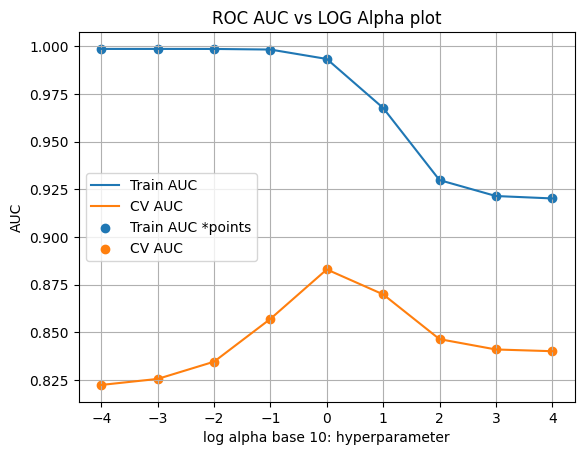

{'alpha': 1.0}
0.8829539125044743
Best alpha log value
0.0


In [112]:
plt.plot(alpha1, train_auc_TfIdf, label='Train AUC')
plt.plot(alpha1, cv_auc_TfIdf, label='CV AUC')
plt.scatter(alpha1, train_auc_TfIdf, label='Train AUC *points')
plt.scatter(alpha1, cv_auc_TfIdf, label='CV AUC')

plt.legend()
plt.xlabel('log alpha base 10: hyperparameter')
plt.ylabel('AUC')
plt.title('ROC AUC vs LOG Alpha plot')
plt.grid()
plt.show()

print(clf_TfIdf.best_params_)
print(clf_TfIdf.best_score_)
print('Best alpha log value')
a_TfIdf = math.log10(clf_TfIdf.best_params_.get('alpha'))
print(a_TfIdf)

The blue line is training AUC meaning training data AUC values. The orange line is cross validation AUC values. We can observe that training accuracy is high whereas testing accuracy is low. This means that the model is overfitting. We can observe that at alpha = 1 i.e. log alpha = 0, the graph is bending down. So this can be taken as the best alpha value.

On the best alpha value, we have to identify the best threshold value which will separate the 2 target classes. Based on the threshold value, we have to plot the confusion matrix.

In [113]:
from sklearn.metrics import roc_curve, auc

We will instantiate **MultinomialNB** model on **alpha=1**

In [114]:
neigh_best_Hyperparameter = MultinomialNB(alpha=1, fit_prior=False, class_prior=l)

In [115]:
vectorizer_tf_gridSearch_best_Hyperparameter = TfidfVectorizer(max_df=0.15, min_df=0, max_features=10000, use_idf=False,norm=None)

In [116]:
pipeline_TfIdf_best_Hyperparameter = make_pipeline(vectorizer_tf_gridSearch_best_Hyperparameter, neigh_best_Hyperparameter)

In [117]:
pipeline_TfIdf_best_Hyperparameter.fit(df_train_TfIdf.cleaned_Review, df_train_TfIdf.Liked)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.15, max_features=10000, min_df=0,
                                 norm=None, use_idf=False)),
                ('multinomialnb',
                 MultinomialNB(alpha=1, class_prior=[0.5, 0.5],
                               fit_prior=False))])

Predicting probability values to draw the ROC curve

In [118]:
vectorizer_tf_probability = TfidfVectorizer(max_df=0.15, min_df=0, max_features=10000, use_idf=False,norm=None)

In [119]:
df_train_TfIdf_cleaned_Review_transformed = vectorizer_tf_probability.fit_transform(df_train_TfIdf.cleaned_Review)

**predict_proba** is a function which will predict the probability values to draw the ROC curve

In [120]:
y_train_pred_TfIdf_best_Hyperparameter = neigh_best_Hyperparameter.predict_proba(df_train_TfIdf_cleaned_Review_transformed)[:,1]

In [121]:
df_test_TfIdf_cleaned_Review_transformed = vectorizer_tf_probability.transform(df_test_TfIdf.cleaned_Review)

In [122]:
y_test_pred_TfIdf_best_Hyperparameter = neigh_best_Hyperparameter.predict_proba(df_test_TfIdf_cleaned_Review_transformed)[:,1]

We will now calculate the fpr value, tpr value and the threshold value for the training and the testing data

In [123]:
train_fpr_TfIdf, train_tpr_TfIdf, tr_thresholds_TfIdf = roc_curve(df_train_TfIdf.Liked, y_train_pred_TfIdf_best_Hyperparameter)

In [124]:
test_fpr_TfIdf, test_tpr_TfIdf, te_thresholds_TfIdf = roc_curve(df_test_TfIdf.Liked, y_test_pred_TfIdf_best_Hyperparameter)

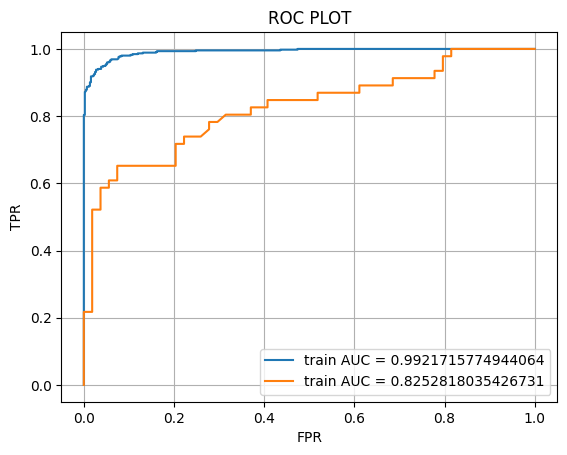

In [125]:
# auc function will calculate the area under curve
plt.plot(train_fpr_TfIdf, train_tpr_TfIdf, label='train AUC = '+str(auc(train_fpr_TfIdf, train_tpr_TfIdf)))
plt.plot(test_fpr_TfIdf, test_tpr_TfIdf, label='train AUC = '+str(auc(test_fpr_TfIdf, test_tpr_TfIdf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()

In the **ROC PLOT**, the blue line shows the training AUC curve and the orange line shows the testing curve

For confusion matrix, we need the threshold value at which we have the best AUC value

In [126]:
def bestthreshold(threshold, fpr, tpr):
  #We will fetch the threshold value at which the the product of tpr and (1-fpr) is the maximum
  t= threshold[np.argmax(tpr*(1-fpr))]
  print('The maximum value of tpr*(1-tpr) = ', max(tpr*(1-fpr)))
  return t

In [127]:
# Defining function to predict using the threshold value 
def predictusingbestt(proba, threshold):
  predictions = []
  for i in proba:
    if i >= threshold:
      # Probabiity value greater than or equal to the threshold value is considered as class 1
      predictions.append(1)
    else:
      # Probabiity value less than the threshold value is considered as class 0
      predictions.append(0)
  return predictions

In [128]:
best_t_TfIdf = bestthreshold(tr_thresholds_TfIdf, train_fpr_TfIdf, train_tpr_TfIdf)

The maximum value of tpr*(1-tpr) =  0.9127761250554368


Plotting the confusion matrix for training data

Train confusion matrix


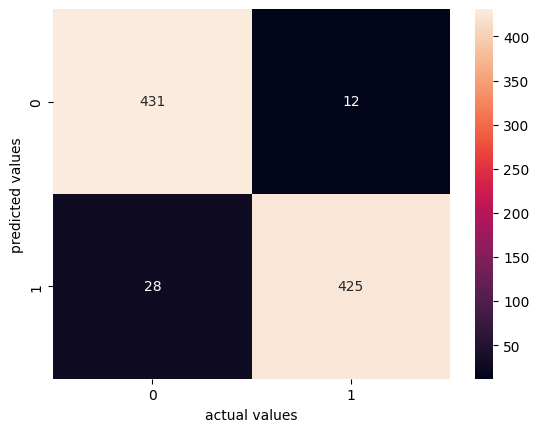

In [129]:
print("Train confusion matrix")
ax = sns.heatmap(confusion_matrix(df_train_TfIdf.Liked, predictusingbestt(y_train_pred_TfIdf_best_Hyperparameter, best_t_TfIdf)),annot=True,fmt='d')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

Plotting the confusion matrix for testing data

Test confusion matrix


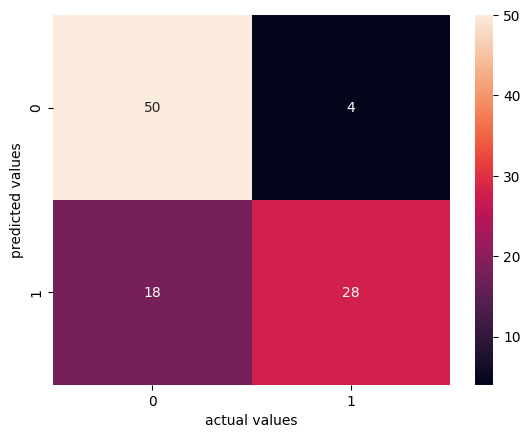

In [130]:
print("Test confusion matrix")
ax = sns.heatmap(confusion_matrix(df_test_TfIdf.Liked, predictusingbestt(y_test_pred_TfIdf_best_Hyperparameter, best_t_TfIdf)),annot=True,fmt='d')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [131]:
score_TfIdf_tuned = accuracy_score(df_test_TfIdf.Liked, predictusingbestt(y_test_pred_TfIdf_best_Hyperparameter, best_t_TfIdf))

In [132]:
score_TfIdf_tuned

0.78

In [133]:
report_TfIdf_tuned = classification_report(df_test_TfIdf.Liked, predictusingbestt(y_test_pred_TfIdf_best_Hyperparameter, best_t_TfIdf))

In [134]:
print(report_TfIdf_tuned)

              precision    recall  f1-score   support

           0       0.74      0.93      0.82        54
           1       0.88      0.61      0.72        46

    accuracy                           0.78       100
   macro avg       0.81      0.77      0.77       100
weighted avg       0.80      0.78      0.77       100



In [135]:
precision_TfIdf_tuned,recall_TfIdf_tuned,fscore_TfIdf_tuned,support_TfIdf_tuned=score(df_test_TfIdf.Liked, predictusingbestt(y_test_pred_TfIdf_best_Hyperparameter, best_t_TfIdf),average='macro')

#### Creating a Word2Vec object

Importing **gensim** library

In [136]:
import gensim

Importing **Word2Vec** from **gensim**

In [137]:
from gensim.models import  Word2Vec

In [138]:
Rest_rev.head()

,Review,Liked,Length,cleaned_Review
0,Wow... Loved this place.,1,24,"['wow', 'loved', 'place']"
1,Crust is not good.,0,18,"['crust', 'not', 'good']"
2,Not tasty and the texture was just nasty.,0,41,"['not', 'tasty', 'texture', 'nasty']"
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1,87,"['stopped', 'during', 'late', 'may', 'bank', 'holiday', 'rick', 'steve', 'recommendation', 'loved']"
4,The selection on the menu was great and so were the prices.,1,59,"['selection', 'menu', 'great', 'price']"


In [139]:
Rest_rev['cleaned_Review_processed'] = Rest_rev['cleaned_Review'].apply(eval)

In [140]:
Rest_rev.head()

,Review,Liked,Length,cleaned_Review,cleaned_Review_processed
0,Wow... Loved this place.,1,24,"['wow', 'loved', 'place']","[wow, loved, place]"
1,Crust is not good.,0,18,"['crust', 'not', 'good']","[crust, not, good]"
2,Not tasty and the texture was just nasty.,0,41,"['not', 'tasty', 'texture', 'nasty']","[not, tasty, texture, nasty]"
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1,87,"['stopped', 'during', 'late', 'may', 'bank', 'holiday', 'rick', 'steve', 'recommendation', 'loved']","[stopped, during, late, may, bank, holiday, rick, steve, recommendation, loved]"
4,The selection on the menu was great and so were the prices.,1,59,"['selection', 'menu', 'great', 'price']","[selection, menu, great, price]"


In [141]:
# Inserting the reviews into an empty list

sentences = []
for i in Rest_rev['cleaned_Review_processed']:
  sentences.append(i)

In [142]:
len(sentences)

996

There are a total of **996** sentences or reviews

In [143]:
sentences[:5]

[['wow', 'loved', 'place'],
 ['crust', 'not', 'good'],
 ['not', 'tasty', 'texture', 'nasty'],
 ['stopped',
  'during',
  'late',
  'may',
  'bank',
  'holiday',
  'rick',
  'steve',
  'recommendation',
  'loved'],
 ['selection', 'menu', 'great', 'price']]

In [144]:
# Checking the version of gensim
print(gensim.__version__)

4.3.1


In [145]:
# upgrade gensim library if the version is lower
if gensim.__version__ != '4.3.1':
  !pip install --upgrade gensim

Creating a **Word2Vec** model

In [146]:
# Setting the vector size
embedding_size = 58

# If there is error while instantiating Word2Vec model, then try restarting the runtime and running entire code again 
model_Word2Vec = Word2Vec(sentences, vector_size = embedding_size, window=10, min_count=2, sg=0, workers=4)

The parameters of **Word2Vec** are explained as below:

 - **window** refers to the window size i.e. the number of words to be considered before and after     a given word in a document. The idea is to learn the context of this particular word by using     the neighbouring words which are before and after that word
 - **vector_size** is the embedding size which means we will encode or embed each of the words        into a vector of size **[1 x 58]** 
 - **min_count=2** means the words appearing atleast twice in a document
 - **sg=0** means we are building a continuous bag of words model

In [147]:
print(model_Word2Vec)

Word2Vec<vocab=750, vector_size=58, alpha=0.025>


In the instantiated **Word2Vec** model, the model has been able to determine that there are **750** unique words in the vocabulary, each word has been constructed into a vector of size 1 x 58 and the learning rate **alpha** is 0.025.

Printing the words in the vocabulary

In [148]:
print(model_Word2Vec.wv.key_to_index.keys())

dict_keys(['food', 'not', 'place', 'good', 'service', 'great', 'back', 'time', 'like', 'go', 'really', 'best', 'would', 'restaurant', 'ever', 'one', 'friendly', 'also', 'never', 'nice', 'amazing', 'delicious', 'vega', 'pretty', 'came', 'experience', 'get', 'even', 'disappointed', 'u', 'definitely', 'eat', 'staff', 'minute', 'love', 'server', 'bad', 'going', 'got', 'chicken', 'steak', 'pizza', 'much', 'star', 'first', 'salad', 'price', 'made', 'say', 'dish', 'better', 'could', 'way', 'menu', 'burger', 'think', 'well', 'always', 'worst', 'wait', 'flavor', 'meal', 'table', 'fresh', 'want', 'ordered', 'quality', 'went', 'feel', 'thing', 'sushi', 'order', 'taste', 'fantastic', 'awesome', 'selection', 'enough', 'night', 'everything', 'after', 'buffet', 'still', 'fry', 'know', 'atmosphere', 'bland', 'slow', 'next', 'come', 'sauce', 'tasty', 'perfect', 'sandwich', 'side', 'waited', 'another', 'recommend', 'coming', 'loved', 'meat', 'breakfast', 'worth', 'little', 'lunch', 'excellent', 'probabl

In [149]:
len(model_Word2Vec.wv.index_to_key)

750

Printing the word vector for the word **would** which is present in the vocabulary

In [150]:
model_Word2Vec.wv.get_vector('would')

array([ 0.01514115, -0.00961324, -0.00660453,  0.00603276,  0.01852614,
       -0.01069007,  0.01285774,  0.02042692, -0.01465452,  0.00351323,
        0.00599983, -0.00313249, -0.00995846, -0.00843316,  0.00095628,
       -0.00433648,  0.01034943, -0.00972805,  0.00560699,  0.0055531 ,
        0.00647502, -0.00054925, -0.0134326 , -0.01639961,  0.00751316,
        0.00944268, -0.00824922, -0.02143599, -0.01703957,  0.00579688,
       -0.00285452,  0.01546   , -0.00699451,  0.01531813, -0.00690597,
        0.01197001,  0.00191412, -0.01845955, -0.00562164,  0.00045019,
       -0.00959364,  0.00189218, -0.01729416,  0.00124275,  0.01724606,
        0.00382173, -0.0099143 ,  0.00651468,  0.01528347, -0.01314945,
       -0.00945721, -0.00932372,  0.01733777, -0.00129032, -0.01784691,
       -0.00743761,  0.02301976, -0.01067937], dtype=float32)

Printing the word vector for the word **burger** which is present in the vocabulary

In [151]:
model_Word2Vec.wv.get_vector('burger')

array([ 0.00613442, -0.00694826, -0.010933  ,  0.01257101,  0.00759333,
       -0.01254189, -0.00170843,  0.00350105, -0.00418407, -0.01087684,
        0.01156552,  0.0064156 ,  0.01249212,  0.01029224, -0.00549632,
        0.00261995,  0.00111417, -0.02277492,  0.01981442,  0.01808374,
        0.01515407, -0.00744275, -0.01657623,  0.008225  , -0.00618441,
        0.01213085, -0.00571582,  0.00431126,  0.00705072, -0.00470236,
        0.00030822,  0.00631908,  0.02162053, -0.0120799 ,  0.00083495,
        0.00241429,  0.01215491,  0.00419304, -0.00693927,  0.00854627,
       -0.0072486 ,  0.00977073,  0.00980621,  0.0027151 , -0.00606677,
        0.00263634,  0.00513194,  0.01712318,  0.01063962, -0.00830426,
       -0.000441  , -0.01533537, -0.00621262,  0.00222831, -0.0132033 ,
       -0.0168477 ,  0.0209992 ,  0.01839776], dtype=float32)

In [152]:
model_Word2Vec.corpus_count

996

Number of epochs for which the **Word2Vec** model has been trained

In [153]:
model_Word2Vec.epochs

5

Defining the function **generate_vector** which will generate and fetch the word vectors of the 750 words in the vocabulary to generate the document vector so that we can convert the documents into a structured format. Each document vector is essentially an average of all the word vectors of all the words in that document

In [154]:
def document_vector(doc):
  #Create document vectors by averaging the word vectors. Remove the out of vocabulary words
  doc1 = [word for word in doc if word in model_Word2Vec.wv.index_to_key]
  #So essentially, doc1 is a collection of those words which are a part of the vocabulary

  wv1 = []

  for word in doc1:
    wv1.append(model_Word2Vec.wv.get_vector(word)) #Fetching the word vector for all the words in the vocabulary
  wv1 = np.array(wv1) #Converting wv1 into a numpy array
  wv1_mean = wv1.mean(axis = 0) #Taking the mean/average row wise
  return wv1_mean

In [155]:
# Generate word vectors for the documents
Review_temp = Rest_rev['cleaned_Review_processed'].apply(document_vector)

<ipython-input-154-c5a7e79dc394>:11: RuntimeWarning: Mean of empty slice.
  wv1_mean = wv1.mean(axis = 0) #Taking the mean/average row wise


Fetching the document vectors from the above list **Review_temp** and convert it into a Numpy array

In [156]:
Review_vec = np.ones((len(Review_temp), embedding_size))*np.nan

In [157]:
for i in range(Review_vec.shape[0]):
  Review_vec[i,:] = Review_temp.iloc[i]

In [158]:
Review_vec.shape

(996, 58)

Converting the Numpy array into a pandas dataframe

In [159]:
Rest_rev_vectorized = pd.DataFrame(Review_vec)

In [160]:
#Adding the column for dependent feature in the Rest_rev_vectorized dataframe
Rest_rev_vectorized['Liked'] = Rest_rev['Liked']

In [161]:
Rest_rev_vectorized.dropna(how='any', axis=0, inplace=True)

In [162]:
Rest_rev_vectorized.head()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,Liked
0,0.003592,0.006200,-0.013609,-0.004918,0.000450,-0.004865,0.004152,0.003265,-0.001836,0.000402,...,0.001226,0.013196,-0.012292,0.008281,-0.006230,-0.002041,-0.006412,0.004471,0.001397,1
1,0.002502,0.001749,-0.006505,-0.005505,0.004584,-0.012269,-0.009285,0.004965,-0.008709,0.007086,...,0.000537,0.001469,-0.005735,0.005812,-0.001860,-0.010096,0.006853,0.010440,0.003866,0
2,-0.001049,0.011581,0.001636,-0.007049,0.001204,-0.006640,-0.002933,0.006772,-0.002908,0.008271,...,0.004912,-0.006462,-0.014360,-0.000134,-0.003848,-0.006394,0.001559,0.003041,-0.000569,0
3,-0.003374,-0.000343,-0.002204,0.002629,0.000738,-0.001872,-0.001381,0.006825,0.000895,0.001059,...,0.002622,0.003508,0.001383,0.001170,-0.008589,-0.001474,-0.000349,0.007294,0.002740,1
4,0.000676,0.006174,-0.000149,0.000358,0.011925,-0.000339,0.000089,-0.003297,0.002364,0.004042,...,-0.002201,0.002006,0.002768,0.001092,0.007932,-0.000372,0.003050,0.007874,0.000308,1


In [163]:
from sklearn.model_selection import train_test_split
df_train_Word2Vec, df_test_Word2Vec = train_test_split(Rest_rev_vectorized, test_size = 0.10, random_state = 42, shuffle=True)

In [164]:
df_train_Word2Vec.reset_index(inplace = True, drop = True)

In [165]:
df_test_Word2Vec.reset_index(inplace = True, drop = True)

In [166]:
df_train_Word2Vec.head()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,Liked
0,-0.005859,0.001262,-0.004870,-0.003850,0.005660,-0.006348,-0.004187,0.005210,-0.009877,0.002308,...,0.001673,0.001281,-0.004972,0.001331,0.005644,-0.006739,-0.002933,0.005369,0.006235,0
1,-0.002150,-0.002342,-0.003549,0.005000,0.001631,-0.005814,-0.000291,-0.005548,0.001108,-0.001014,...,0.001323,-0.001191,0.000936,0.000641,0.009418,-0.001724,-0.007271,-0.004423,-0.001694,1
2,-0.002294,-0.000286,-0.004041,-0.001389,0.010319,0.008944,-0.007747,0.012395,-0.010888,0.007702,...,-0.013157,0.002927,0.000356,0.000254,-0.003881,-0.003330,-0.001334,0.007405,-0.004436,1
3,0.008041,-0.005558,0.001884,-0.001619,-0.007411,-0.006086,0.010732,-0.003212,-0.006691,0.003450,...,0.014956,0.004234,-0.014505,-0.001995,-0.005234,-0.000044,-0.003840,-0.007514,-0.000463,1
4,0.007423,-0.000326,0.000167,0.002135,0.008897,-0.000864,-0.000335,0.003193,-0.000633,-0.003426,...,0.006201,-0.004612,0.007374,-0.000674,-0.001055,-0.002856,-0.004560,0.002012,0.002926,0


In [167]:
df_test_Word2Vec.head()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,Liked
0,0.009019,0.015043,-0.001697,0.003527,0.004379,-0.004334,-0.001727,0.017681,-0.005322,0.007757,...,-0.003315,0.016576,0.003404,-0.016255,-0.006841,-0.010042,0.003220,-0.004463,0.008135,0
1,0.003830,0.007007,-0.003462,-0.013122,0.013055,-0.005710,-0.003722,0.008124,-0.001790,-0.011298,...,0.005368,0.007101,-0.007117,0.002455,-0.010168,0.011496,-0.009973,0.013363,-0.000836,1
2,-0.005493,0.007423,-0.009414,-0.001704,0.004094,0.002563,0.000903,0.008062,-0.009580,0.018646,...,0.004868,0.008023,-0.001219,0.006014,-0.001435,-0.006654,0.002052,0.004817,-0.005159,1
3,-0.001423,0.001791,-0.011134,0.006362,0.007273,0.003615,0.008489,0.003788,-0.013533,0.006854,...,0.006743,0.004705,0.001386,0.010047,-0.007717,-0.004867,0.002452,0.010315,-0.000554,1
4,0.000536,0.009768,-0.010319,0.001572,-0.000409,-0.007702,-0.007633,-0.001926,-0.008482,0.005568,...,-0.004592,0.004905,-0.004906,0.000526,-0.007790,-0.001776,-0.008898,0.015796,0.007979,0


Implementing **MinMaxScaler** to scale the document vectors to the range of 0 to 1.

In [168]:
from sklearn.preprocessing import MinMaxScaler

In [169]:
scaling = MinMaxScaler()

In [170]:
X_train_scaled = scaling.fit_transform(df_train_Word2Vec.iloc[:,:-1])

In [171]:
X_train_scaled

array([[0.31216202, 0.49607566, 0.41846372, ..., 0.52879252, 0.55945002,
        0.63558453],
       [0.42231848, 0.37845224, 0.45573488, ..., 0.42227628, 0.29279254,
        0.39423294],
       [0.41805226, 0.44554786, 0.44185695, ..., 0.56805911, 0.61490933,
        0.31074827],
       ...,
       [0.59761232, 0.61961108, 0.38828027, ..., 0.52590496, 0.45972414,
        0.38627663],
       [0.6586812 , 0.47895685, 0.33018522, ..., 0.47997096, 0.51753602,
        0.6012719 ],
       [0.15488892, 0.46586378, 0.41969748, ..., 0.42398501, 0.52662433,
        0.8685595 ]])

In [172]:
X_train = pd.DataFrame(X_train_scaled, columns=df_train_Word2Vec.iloc[:,:-1].columns)

In [173]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
count,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,...,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000
mean,0.496843,0.491886,0.467611,0.470614,0.498763,0.474287,0.498828,0.500714,0.490618,0.516959,...,0.510068,0.511414,0.508737,0.479906,0.521832,0.486415,0.437635,0.499107,0.571706,0.488306
std,0.168242,0.177340,0.159429,0.153714,0.155799,0.174357,0.158873,0.146007,0.141836,0.162944,...,0.166896,0.165009,0.178872,0.150643,0.178148,0.152112,0.170975,0.138083,0.164488,0.170521
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.390473,0.381882,0.366415,0.378439,0.402275,0.360230,0.392237,0.410716,0.404882,0.412624,...,0.410092,0.415636,0.400308,0.388246,0.410433,0.393776,0.324255,0.410508,0.472970,0.378495
50%,0.495751,0.484593,0.464403,0.467012,0.497617,0.479814,0.501347,0.503186,0.489694,0.521555,...,0.509621,0.511941,0.514499,0.477468,0.526080,0.491872,0.433193,0.501411,0.572529,0.486815
75%,0.596393,0.598441,0.566267,0.559313,0.593547,0.577365,0.598227,0.588888,0.577875,0.623251,...,0.612151,0.604521,0.616464,0.569631,0.628785,0.586803,0.539250,0.585337,0.679875,0.595251
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [174]:
X_test_scaled = scaling.transform(df_test_Word2Vec.iloc[:,:-1])

In [175]:
X_test_scaled

array([[0.75402157, 0.9458886 , 0.50801467, ..., 0.67988813, 0.29170694,
        0.69343529],
       [0.59992005, 0.68360172, 0.45819925, ..., 0.35593596, 0.77714285,
        0.42033882],
       [0.32303755, 0.69715977, 0.29021555, ..., 0.65120068, 0.5444268 ,
        0.28876062],
       ...,
       [0.38818206, 0.58984632, 0.62765506, ..., 0.69311889, 0.58578265,
        0.34082243],
       [0.50980618, 0.67031848, 0.35578932, ..., 0.48218922, 0.49414918,
        0.85042857],
       [0.58868856, 0.21848786, 0.50773215, ..., 0.47341859, 0.48904883,
        0.76488103]])

In [176]:
X_test = pd.DataFrame(X_test_scaled, columns=df_train_Word2Vec.iloc[:,:-1].columns)

In [177]:
X_test.describe()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,...,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,0.528606,0.470652,0.460792,0.458067,0.515043,0.442869,0.510045,0.516875,0.493478,0.534318,...,0.520607,0.514087,0.542778,0.465480,0.542984,0.491085,0.415858,0.493302,0.591122,0.513868
std,0.138598,0.171523,0.157956,0.150116,0.146822,0.188233,0.178042,0.146072,0.138275,0.144478,...,0.161817,0.159547,0.180841,0.162019,0.203013,0.136665,0.167202,0.130496,0.165863,0.173230
min,0.261307,-0.077006,0.075064,0.064865,0.090161,0.010649,0.000000,0.100475,0.108098,0.123428,...,0.143906,0.077274,0.087005,0.120974,-0.037527,0.127841,0.087579,0.150749,0.027873,0.115196
25%,0.420508,0.357954,0.356129,0.358935,0.421364,0.321977,0.406292,0.426866,0.425842,0.466632,...,0.406868,0.416238,0.439244,0.364615,0.421295,0.392206,0.316293,0.411418,0.490437,0.413079
50%,0.532196,0.487736,0.471090,0.472818,0.519697,0.436808,0.494429,0.513581,0.489697,0.538257,...,0.500343,0.507669,0.525068,0.475423,0.549290,0.491510,0.406590,0.497667,0.591644,0.514235
75%,0.623540,0.578419,0.545660,0.551660,0.611667,0.539138,0.623809,0.594940,0.582889,0.611911,...,0.623849,0.623489,0.647473,0.574383,0.686124,0.561731,0.518932,0.596878,0.717662,0.618581
max,0.974539,0.945889,0.866095,0.815681,0.864943,0.972211,0.998720,0.978583,0.823310,0.992447,...,1.021615,1.006643,0.986480,0.895016,0.986562,0.837719,0.841535,0.708861,0.885422,0.936492


Instantiating the **Multinomial Navie Bayes** model

In [178]:
mnb = MultinomialNB()

Training the model

In [179]:
mnb.fit(X_train, df_train_Word2Vec.Liked)

MultinomialNB()

Predicting on the test dataframe

In [180]:
labels_Word2Vec = mnb.predict(X_test)

In [181]:
mat_Word2Vec = confusion_matrix(df_test_Word2Vec.Liked, labels_Word2Vec)

Text(113.9222222222222, 0.5, 'Predicted label')

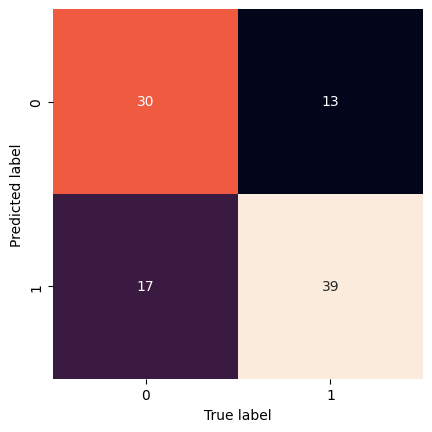

In [182]:
sns.heatmap(mat_Word2Vec.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label')

The following observations can be concluded about the performance:

 - 40 is the number of true positives i.e. The number of actual negative reviews that were predicted negatively be the model

 - 60 is the number of true negatives i.e. The number of actual positive reviews that were predicted positively be the model

 - 34 is the number of false positives i.e. The number of actual negative reviews that were predicted positively be the model

 - 14 is the number of false negatives i.e. The number of actual positive reviews that were predicted negatively be the model

In [183]:
score_Word2Vec = accuracy_score(df_test_Word2Vec.Liked, labels_Word2Vec)

In [184]:
score_Word2Vec

0.696969696969697

In [185]:
report_Word2Vec = classification_report(df_test_Word2Vec.Liked, labels_Word2Vec)

In [186]:
print(report_Word2Vec)

              precision    recall  f1-score   support

           0       0.70      0.64      0.67        47
           1       0.70      0.75      0.72        52

    accuracy                           0.70        99
   macro avg       0.70      0.69      0.69        99
weighted avg       0.70      0.70      0.70        99



In [187]:
precision_Word2Vec,recall_Word2Vec,fscore_Word2Vec,support_Word2Vec=score(df_test_Word2Vec.Liked, labels_Word2Vec,average='macro')

We will use **GridSearchCV** for Hyperparameter tuning

In [188]:
m = [0.5, 0.5] # Taking equal priority values

In [189]:
neigh_Word2Vec = MultinomialNB(fit_prior=False, class_prior=l)

In [190]:
alphas_Word2Vec = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]) 

In [191]:
# Placing alpha values in a dictionary
tuned_parameters_Word2Vec = {'alpha' : alphas_Word2Vec}

In [192]:
clf_Word2Vec = GridSearchCV(neigh_Word2Vec, tuned_parameters_Word2Vec, cv=5, scoring = 'roc_auc', return_train_score=True)

In [193]:
clf_Word2Vec.fit(X_train, df_train_Word2Vec.Liked)

GridSearchCV(cv=5,
             estimator=MultinomialNB(class_prior=[0.5, 0.5], fit_prior=False),
             param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])},
             return_train_score=True, scoring='roc_auc')

In [194]:
results_Word2Vec = pd.DataFrame.from_dict(clf_Word2Vec.cv_results_)

In [195]:
#Sorting the results dataframe based on the param_alpha values
results_Word2Vec = results_Word2Vec.sort_values(['param_alpha'])

In [196]:
train_auc_Word2Vec = results_Word2Vec['mean_train_score']

In [197]:
cv_auc_Word2Vec = results_Word2Vec['mean_test_score']

In [198]:
k_Word2Vec = results_Word2Vec['param_alpha']

In [199]:
#alpha value is taken log alpha value for better visualization
alpha2 = []

for i in range(0, len(k_Word2Vec), 1):
  o = math.log10(k_Word2Vec[i])
  alpha2.append(o)
alpha2.sort()

In [200]:
print(alpha2)

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


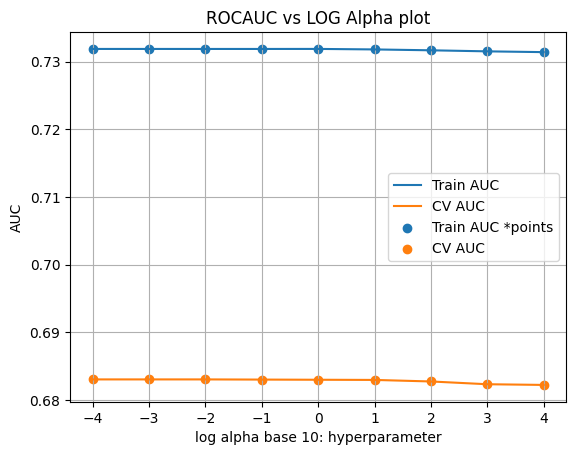

{'alpha': 0.0001}
0.6830345973304564
Best alpha log value
-4.0


In [201]:
plt.plot(alpha2, train_auc_Word2Vec, label='Train AUC')
plt.plot(alpha2, cv_auc_Word2Vec, label='CV AUC')
plt.scatter(alpha2, train_auc_Word2Vec, label='Train AUC *points')
plt.scatter(alpha1, cv_auc_Word2Vec, label='CV AUC')

plt.legend()
plt.xlabel('log alpha base 10: hyperparameter')
plt.ylabel('AUC')
plt.title('ROCAUC vs LOG Alpha plot')
plt.grid()
plt.show()

print(clf_Word2Vec.best_params_)
print(clf_Word2Vec.best_score_)
print('Best alpha log value')
a_Word2Vec = math.log10(clf_Word2Vec.best_params_.get('alpha'))
print(a_Word2Vec)

As per the above output, the best value of alpha = 0.1

In [202]:
neigh_Word2Vec_best_Hyperparameter = MultinomialNB(alpha=0.1, fit_prior=False, class_prior=l)

In [203]:
neigh_Word2Vec_best_Hyperparameter.fit(X_train, df_train_Word2Vec.Liked)

MultinomialNB(alpha=0.1, class_prior=[0.5, 0.5], fit_prior=False)

In [204]:
y_train_pred_Word2Vec_best_Hyperparameter = neigh_Word2Vec_best_Hyperparameter.predict_proba(X_train)[:,1]

In [205]:
y_test_pred_Word2Vec_best_Hyperparameter = neigh_Word2Vec_best_Hyperparameter.predict_proba(X_test)[:,1]

In [206]:
train_fpr_Word2Vec, train_tpr_Word2Vec, tr_thresholds_Word2Vec = roc_curve(df_train_Word2Vec.Liked, y_train_pred_Word2Vec_best_Hyperparameter)

In [207]:
test_fpr_Word2Vec, test_tpr_Word2Vec, te_thresholds_Word2Vec = roc_curve(df_test_Word2Vec.Liked, y_test_pred_Word2Vec_best_Hyperparameter)

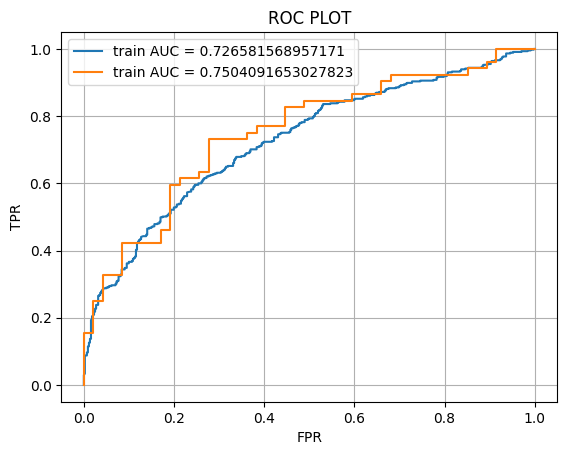

In [208]:
# auc function will calculate the area under curve
plt.plot(train_fpr_Word2Vec, train_tpr_Word2Vec, label='train AUC = '+str(auc(train_fpr_Word2Vec, train_tpr_Word2Vec)))
plt.plot(test_fpr_Word2Vec, test_tpr_Word2Vec, label='train AUC = '+str(auc(test_fpr_Word2Vec, test_tpr_Word2Vec)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()

In [209]:
best_t_Word2Vec = bestthreshold(tr_thresholds_Word2Vec, train_fpr_Word2Vec, train_tpr_Word2Vec)

The maximum value of tpr*(1-tpr) =  0.4514560880531988


Train confusion matrix


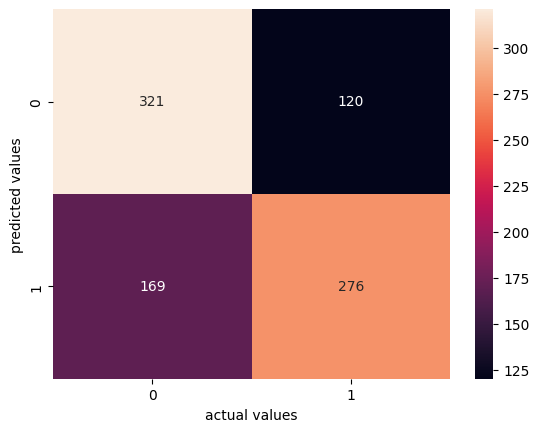

In [210]:
print("Train confusion matrix")
ax = sns.heatmap(confusion_matrix(df_train_Word2Vec.Liked, predictusingbestt(y_train_pred_Word2Vec_best_Hyperparameter, best_t_Word2Vec)),annot=True,fmt='d')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

Test confusion matrix


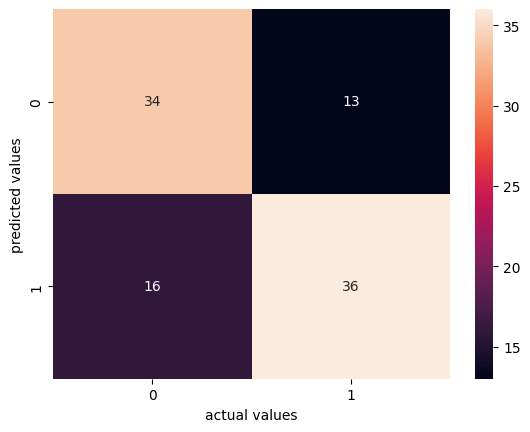

In [211]:
print("Test confusion matrix")
ax = sns.heatmap(confusion_matrix(df_test_Word2Vec.Liked, predictusingbestt(y_test_pred_Word2Vec_best_Hyperparameter, best_t_Word2Vec)),annot=True,fmt='d')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [212]:
score_Word2Vec_tuned = accuracy_score(df_test_Word2Vec.Liked, predictusingbestt(y_test_pred_Word2Vec_best_Hyperparameter, best_t_Word2Vec))

In [213]:
score_Word2Vec_tuned

0.7070707070707071

In [214]:
report_Word2Vec_tuned = classification_report(df_test_Word2Vec.Liked, predictusingbestt(y_test_pred_Word2Vec_best_Hyperparameter, best_t_Word2Vec))

In [215]:
print(report_Word2Vec_tuned)

              precision    recall  f1-score   support

           0       0.68      0.72      0.70        47
           1       0.73      0.69      0.71        52

    accuracy                           0.71        99
   macro avg       0.71      0.71      0.71        99
weighted avg       0.71      0.71      0.71        99



In [216]:
precision_Word2Vec_tuned,recall_Word2Vec_tuned,fscore_Word2Vec_tuned,support_Word2Vec_tuned=score(df_test_Word2Vec.Liked, predictusingbestt(y_test_pred_Word2Vec_best_Hyperparameter, best_t_Word2Vec),average='macro')

### Formatted table to compare the models

In [217]:
from prettytable import PrettyTable

In [218]:
# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Model Name", "Testing Accuracy (%)", "Precision", "Recall", "F-score", "Support"])

In [219]:
# Adding rows to the table
myTable.add_row(["MultinomialNB using TfIDF", round(score_TfIdf*100, 3), round(precision_TfIdf, 3), round(recall_TfIdf, 3), round(fscore_TfIdf, 3), support_TfIdf])
myTable.add_row(["MultinomialNB using Word2Vec", round(score_Word2Vec*100,3), round(precision_Word2Vec, 3), round(recall_Word2Vec, 3), round(fscore_Word2Vec, 3), support_Word2Vec])
myTable.add_row(["MultinomialNB tuned model using TfIDF", round(score_TfIdf_tuned*100, 3), round(precision_TfIdf_tuned, 3), round(recall_TfIdf_tuned, 3), round(fscore_TfIdf_tuned, 3), support_TfIdf_tuned])
myTable.add_row(["MultinomialNB tuned model using Word2Vec", round(score_Word2Vec_tuned*100,3), round(precision_Word2Vec_tuned, 3), round(recall_Word2Vec_tuned, 3), round(fscore_Word2Vec_tuned, 3), support_Word2Vec_tuned])

In [220]:
print(myTable)

+------------------------------------------+----------------------+-----------+--------+---------+---------+
|                Model Name                | Testing Accuracy (%) | Precision | Recall | F-score | Support |
+------------------------------------------+----------------------+-----------+--------+---------+---------+
|        MultinomialNB using TfIDF         |         78.0         |   0.792   | 0.771  |  0.773  |   None  |
|       MultinomialNB using Word2Vec       |        69.697        |   0.697   | 0.694  |  0.694  |   None  |
|  MultinomialNB tuned model using TfIDF   |         78.0         |   0.805   | 0.767  |  0.769  |   None  |
| MultinomialNB tuned model using Word2Vec |        70.707        |   0.707   | 0.708  |  0.707  |   None  |
+------------------------------------------+----------------------+-----------+--------+---------+---------+


## Comparison between TfIDF Vectorizer and Word2Vec Vectorizer

**TfIdf vectorizer** takes the importance of words by considering 2 things.
First is the frequency of a word in the document. The words which are common will have more frequency and they will be less important. But the model may consider those words to be very important.

Suppose a document is about electric cars. In such a document, the word car, automobile, vehicle etc are domain specific words and these may occur many times in this document. So these words may not impact much meaning to the document. To reduce the importance given to such words, we can do inverse document frequency using TfIdf vectorizer.

But while using TfIdf vectorizer, the sequence information of the text is lost. This will reduce the accuracy.

Using TfIdf, we will not get much semantic information about the text. To overcome this drawback, we will use the concept of word embeddings. Word2Vec is a word embedding technique

**Word2Vec vectorizer** follows 2 different process of predicting the vector representation of the word :

- Continuous bag of words (CBOW)
- Skipgram

Both CBOW and skip gram use a neural network.

In CBOW, we predict a word based on the context.

In Skip gram, we predict the context based on the word.

Suppose we have a dictionary that has 10,000 words. Suppose the word man is present in this dictionary at the 5000th position. We can convert this word man into a vector representation in a one hot encoded form. Suppose we have a word woman which is present in the 9000th position. We can convert this word woman into a vector representation in a one hot encoded form.

The one hot representation has a lot of zero i.e. it is a sparse matrix. The size of this matrix is very huge. The ML algorithm will find it difficult to generalize this representation.

To overcome the above drawbacks, we will use the word embedding

In word embedding, there is a concept of feature representation.

Suppose we have some words. We will convert these words into vectors based on some features. We can consider any number of random features like Gender, Age, Food etc. The feature gender is related to Boy, Girl, King and Queen. But this feature is not related to Apple and Mango. The feature royal is related to the King and Queen.

The advantage of feature representation is that the dimension of the vector is equal to the number of features. Also the matrix obtained is a dense matrix.

## Dependency Parsing

Dependency parsing is the process of extracting the dependent words from the sentences. Dependency parsing means how one word is dependent on another word.

Importing **spacy** and **displacy**. displacy is a tool inside spacy which will display the dependencies between the words in a sentence

In [221]:
import spacy
from spacy import displacy

We will load the **spacy** model which is already pretrained

In [222]:
nlp = spacy.load('en_core_web_sm')

In [223]:
options={'compact':True, 'distance':110, 'bg':'#00FFFF', 'color':'#ff0000'}
for i in Rest_rev.Review[:3]:
  # Creating a doc object from the review using spacy model
  doc = nlp(i)
  # displaying the dependency parser
  displacy.render(doc, style='dep', jupyter=True, options=options)

The below are the arguments passed to **displacy** :

 - **style** argument is the style of parsing which is dependency or dep in this case
 - **jupyter=True** will enable the dependency parsing to be displayed on google colab as well
 - **compact=True** argument will draw straight lines instead of curved lines
 - **distance** argument will control the size of the dependency parsing diagram
 - **bg** argument controls the background color
 - **color** argument controls the font color of the text

The following conclusions can be drawn from the dependency parsing:

 - In the first sentence, the word **Loved** is a **VERB** which is dependent on the word **place** which is a **NOUN**
 - In the second sentence, the word **Crust** is a **NOUN** which is dependent on the word **is** which in turn is dependent on the word **good** which is an **ADJECTIVE**
 - In the third sentence, the word **Not** is a **PART** which is dependent on the word **tasty** which is an **ADJECTIVE** which in turn is dependent on the word **was**

Let us look at the dependency parsing of a few more sentences

In [224]:
options={'compact':False, 'distance':110, 'bg':'#00FFFF', 'color':'#ff0000'}
for i in Rest_rev.Review[7:10]:
  # Creating a doc object from the review using spacy model
  doc = nlp(i)
  # displaying the dependency parser
  displacy.render(doc, style='dep', jupyter=True, options=options)